# Task 4

The MaxCut problem is a well-known optimization problem in which the nodes of a given undirected graph have to be divided in two sets (often referred as the set of “white” and “black” nodes) such that the number of edges connecting a white node with a black node are maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be useful (for an explanation of the QAOA algorithm you can read [this blogpost](https://www.google.com/url?q=https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained&sa=D&source=editors&ust=1613908351492000&usg=AOvVaw1nWFzZlI9r-v8xEgdwPHFU)).

At [this link](https://lucaman99.github.io/new_blog/2020/mar16.html) you can find an explicit implementation of the QAOA algorithm to solve the MaxCut problem for the simpler case of an unweighted graph. We ask you to generalize the above code to include also the solution for the case of weighted graphs. You can use the same code or you can also do an alternative implementation using, for example, qiskit. The important point is that you do not make use of any built-in QAOA functionalities.


## Solution

In accordance with the content of the task I will extend the code from Jack Ceroni's post. Code will be written in batches similar to batches from the post, so the reader may keep up with changes I’m introducing. I’ve decided to use `qiskit`, so all circuit related parts will be rewritten.

### Intro
Firstly, let's make our graphs weighted and define an initial graph (looking like a bow tie) with an obvious MaxCut solution separating the central vertex from the rest. 

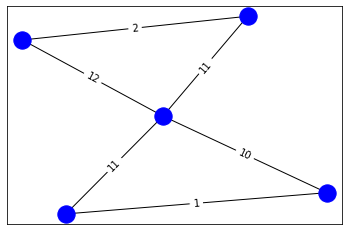

<Figure size 432x288 with 0 Axes>

In [1]:
%matplotlib inline
import networkx as nx
from matplotlib import pyplot as plt

NX_SEED = 42

class Graph:
    def __init__(self, edges):
        self.edges = edges
        self.node_set = set()
        
        for e in edges:
            self.node_set.add(e.start_node)
            self.node_set.add(e.end_node)
        
        self.nodes_num = len(self.node_set)
    
    def to_nx(self):
        G = nx.Graph()
        
        for e in self.edges:
            G.add_edge(str(e.start_node), str(e.end_node), weight=e.weight)
    
        return G


class Edge:
    def __init__(self, start_node, end_node, weight):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight


edges = [
    Edge(0, 1, 10),
    Edge(0, 2, 11),
    Edge(0, 3, 12),
    Edge(0, 4, 11),
    Edge(4, 3, 2),
    Edge(1, 2, 1)
]    

graph = Graph(edges)
G = graph.to_nx()

layout = nx.spring_layout(G, seed=NX_SEED)
labels = nx.get_edge_attributes(G,'weight')

nx.draw_networkx_nodes(G, pos=layout, node_color='blue')
nx.draw_networkx_edges(G, pos=layout)
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

plt.show()
plt.clf()

I will change the original approach to keep qubits list in favour of qiskit's `QuantumCircuit`. All methods will modify the circuit in place. It's worth making our setup more general, as we may want to test this code on some random generated graphs.

In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

DEPTH = 4
REP = 20000

### QAOA

Primary solution didn't allow to inject graph as dependency and held it as a globally defined variable. This approach is fine, but if we would like to run this as an experiment on some random generated graphs within the same notebook it needs to be slightly refactored. That’s why I’ve wrapped it in a simple class responsible for holding and constructing quantum circuit.

This is the first moment, when we need to adjust the code to handle weighted graphs. While `mixer_unitary` remains unchanged, `cost_unitary` depends on $H_C$ Hamiltonian which changes its form:

from $H_C = \sum\limits_{\{i,j\} \in E} \frac{1}{2}(1-\sigma_i^Z \sigma_j^Z)$

to $H_C = \sum\limits_{\{i,j\} \in E} \frac{1}{2}w_{ij}(1-\sigma_i^Z \sigma_j^Z)$

Following the advice from [Musty Thoughts](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained#what-does-the-circuit-look-like) and the conclusion based on [this paper](https://arxiv.org/pdf/1001.3855.pdf) the proper cost implementation is based on $e^{\frac{1}{2}\lambda}R_Z(\lambda)$, which is simply $U1(\lambda)$. [U1Gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.U1Gate.html) is being deprecated, so I will use [PhaseGate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html#qiskit.circuit.library.PhaseGate) (which is equivalent)

In [3]:
from qiskit import QuantumCircuit

class QAOACirc:
    def __init__(self, graph):
        self.graph = graph
        self.circ = QuantumCircuit(graph.nodes_num, graph.nodes_num)

        self.initialization()
        
    def initialization(self):
        self.circ.h(range(self.circ.num_qubits))

    # Defines the cost unitary
    def cost_unitary(self, gamma):
        for e in self.graph.edges:
            self.circ.cp(gamma*e.weight, e.start_node, e.end_node)
            self.circ.p(0.5*gamma*e.weight, e.start_node)
            self.circ.p(0.5*gamma*e.weight, e.end_node)
        
        self.circ.barrier()

    # Defines the mixer unitary
    def mixer_unitary(self, alpha):
        self.circ.rx(2*alpha, range(self.circ.num_qubits))
        self.circ.barrier()
        
    def measure(self):
        self.circ.measure(range(self.graph.nodes_num), range(self.graph.nodes_num))
    
    def draw(self):
        return self.circ.draw(output='mpl')

Proceed, the same as in the original paper, while reimplementing algorithm in `qiskit`. Parameter responsible for simulations number has been raised (after the first few tries), to improve the quality of results.

In [4]:
from qiskit import Aer, execute

# Executes the circuit

def create_circuit(params, graph):

    gamma = [params[0], params[2], params[4], params[6]]
    alpha = [params[1], params[3], params[5], params[7]]

    qaoa = QAOACirc(graph)
    
    for i in range(0, DEPTH):
        qaoa.cost_unitary(gamma[i])
        qaoa.mixer_unitary(alpha[i])
    
    qaoa.measure()
    
    backend = Aer.get_backend("qasm_simulator")

    simulate = execute(qaoa.circ, backend=backend, shots=REP)
    results = simulate.result()

    return results.get_counts(), qaoa

Now we encounter the second piece of the solution which requires to be adjusted - `cost_function`. Cost fraction from each edge needs to be multiplied by its weight.

In [5]:
# Cost for single state

def cost_for_state(state_str, edges):
    state = [int(c) for c in state_str]
    state_cost = 0
    for e in edges:
        state_cost += 0.5 * e.weight * ((1 - 2*state[e.start_node])*(1 - 2*state[e.end_node]) - 1)
    
    return state_cost

# Defines the cost function

def cost_function(params, graph):

    counts, _ = create_circuit(params, graph)
    
    total_cost = 0
    for state_str, count in counts.items():
        total_cost += cost_for_state(state_str, graph.edges) * count
   
    total_cost = float(total_cost)/REP

    print("Cost: {}".format(total_cost))

    return total_cost

We come to the final part of the solution. With reimplemented QAOA we need to run classical minimization of the parameters to get an approximate result. Little has changed, except that cost function requires a graph (which is provided by hof wrapping it)

Cost: -27.0962
Cost: -24.14095
Cost: -23.34165
Cost: -22.98475
Cost: -29.4794
Cost: -27.534
Cost: -20.99515
Cost: -21.6365
Cost: -27.74865
Cost: -23.77695
Cost: -28.7669
Cost: -21.4792
Cost: -22.9252
Cost: -25.2808
Cost: -25.91855
Cost: -25.1063
Cost: -25.6286
Cost: -22.4441
Cost: -24.8288
Cost: -24.1704
Cost: -26.48755
Cost: -28.4249
Cost: -25.36205
Cost: -24.97665
Cost: -28.86295
Cost: -25.41215
Cost: -23.9262
Cost: -30.5662
Cost: -31.5119
Cost: -29.9274
Cost: -30.0867
Cost: -29.1065
Cost: -30.7518
Cost: -31.62495
Cost: -28.35695
Cost: -31.81855
Cost: -31.88465
Cost: -31.6024
Cost: -31.22275
Cost: -30.19755
Cost: -31.58915
Cost: -31.16045
Cost: -31.6058
Cost: -31.0771
Cost: -31.7357
Cost: -30.29505
Cost: -31.4405
Cost: -31.6671
Cost: -31.58745
Cost: -31.55545
Cost: -31.74905
Cost: -31.6814
Cost: -31.5545
Cost: -31.81275
Cost: -31.7763
Cost: -31.83295
Cost: -31.71955
Cost: -31.81885
Cost: -31.6889
Cost: -31.66625
Cost: -31.66905
Cost: -31.63195
Cost: -31.66075
Cost: -31.7051
Cost: -31

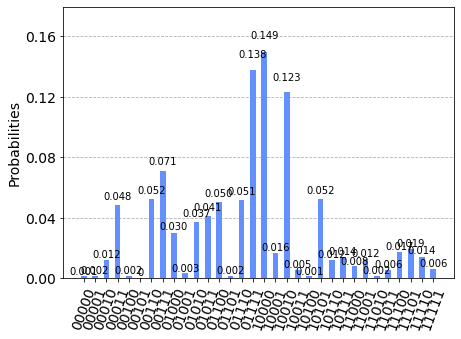

In [6]:
from qiskit.visualization import plot_histogram

# Higher-order function for graph injection into cost function

def with_graph(func, graph):
    def wrapper(params):
        return func(params, graph)
    
    return wrapper
 
# Defines the optimization method

def solve(graph):
    init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
    out = minimize(with_graph(cost_function, graph), x0=init, method="COBYLA", options={'maxiter':1000})
    print(out)

    optimal_params = out['x']
    return create_circuit(optimal_params, graph)

f, circ = solve(graph)
plot_histogram(f)

It may be worth to check more than the top one of the returned solutions

In [7]:
# TOP 3 solutions
def get_top3(results):
    return sorted(results.items(), key=lambda x: x[1], reverse=True)[:3]

top3 = get_top3(f)
top3

[('10000', 2990), ('01111', 2754), ('10010', 2463)]

Please note that first 2. are symetric cases of the most optimal solution :)

### Results

Visualization perfectly shows the essence and the simplicity of the algorithm - on top of state prepared by hadamard gates we stack some (in our case 4) parametrized layers of cost and mixer unitaries.

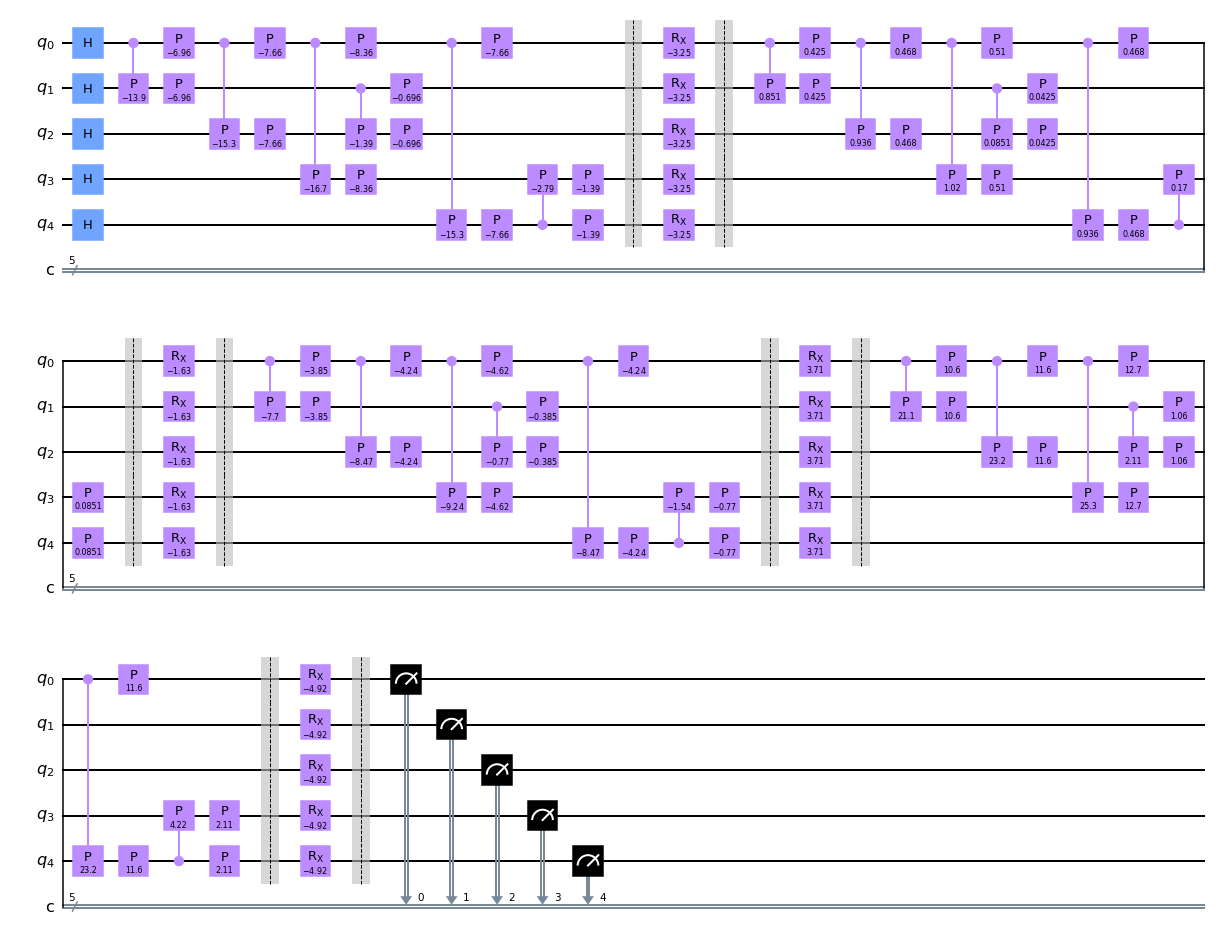

In [8]:
circ.draw()

With `nx` we can easily visualize retrieved MaxCut:

In [9]:
def draw_cut_for_state(state_str, graph):
    G = graph.to_nx()
    layout = nx.spring_layout(G, seed=NX_SEED)
    labels = nx.get_edge_attributes(G,'weight')

    nx.draw_networkx_nodes(G, pos=layout, node_color=['blue' if c == '1' else 'red' for c in state_str])
    nx.draw_networkx_edges(G, pos=layout)
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

    plt.show()
    plt.clf()

As we expected since the very beginning, we maximize the cut with one set consisting only of the central node.

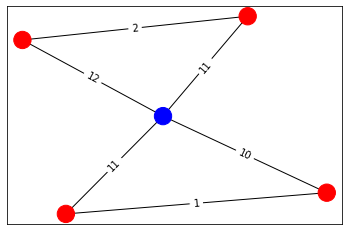

<Figure size 432x288 with 0 Axes>

In [10]:
draw_cut_for_state(top3[0][0], graph)

In [11]:
cost_for_state(top3[0][0], graph.edges)

-44.0

### Experiments

In order to assure that solution is the best we may search space of all solutions which has exponential size of $2^n$, where $n$ is the number of graph nodes. (As the problem is NP-Complete) Usually it’s out of our capabilities and that’s why we need to look for approximate solutions, but it may be necessary to benchmark implementation with small problem instances.

In [12]:
# Returns costs for all solutions in ascending order

def bruteforce_maxcuts(graph):
    n = graph.nodes_num
    solutions_num = 2**n
    all_binary_strings = ["{0:b}".format(i).zfill(n) for i in range(solutions_num)]
    all_solutions = {
        state: cost_for_state(state, graph.edges) for state in all_binary_strings
    }
    return [score for state, score in sorted(all_solutions.items(), key=lambda x: x[1])]

bruteforce_maxcuts(graph)[0]

-44.0

With implementation ready it's time to write some simple benchamrks on random generated graphs.

In [13]:
from itertools import combinations

# Return random graph with n nodes at most. The greater the probability p, the denser the graph will be

def get_random_graph(n, p):
    V = range(n)
    actual_V = set()
    E = []
    
    for (v1, v2) in combinations(V, 2):
        a = random.random()
        if a < p:
            E.append((v1, v2))
            actual_V.add(v1)
            actual_V.add(v2)
    
    V_mapping = {}
    edges = []
    for i, v in enumerate(actual_V): 
        V_mapping[v] = i
    
    for v1, v2 in E:
        w = int(random.random() * 10) + 1
        edges.append(Edge(V_mapping[v1], V_mapping[v2], w))
            
    return Graph(edges)

The intention is to implement a simple benchmark which will fit in max 30 minutes of computation, therefore I will generate 100 random relatively small graphs (8 nodes) and evaluate solutions found by QAOA. Due to the nature of the approximate solutions I will check percentile for all obtained results. It will allow me to judge how good the approximation is.

In [14]:
# Generate random graph and return percentile defining how many solutions were at most as good as the obtained one

def eval_for_graph(graph):
    res, _circ = solve(graph)
    score = min([cost_for_state(s, graph.edges) for s, _ in get_top3(res)])
    
    all_scores = bruteforce_maxcuts(graph)
    return int(100.0*float(len(all_scores)-bruteforce_maxcuts(graph).index(score))/len(all_scores))
    

Proposed evaluation method runs QAOA for the provided graph, finds scores for all possible solutions and returns value $k$ meaning $k%$ of the solutions were at most as good as the obtained one. We will collect these scores and present their histogram

In [15]:
experiments = 100

graphs = [get_random_graph(8, 0.4) for _i in range(experiments)]

In [16]:
%%capture
percentils = []

for graph in graphs:
    percentils.append(eval_for_graph(graph))

The higher the bar at $x$, the more experiments ended with result equal to bar's height in terms of proposed evaluation

<BarContainer object of 101 artists>

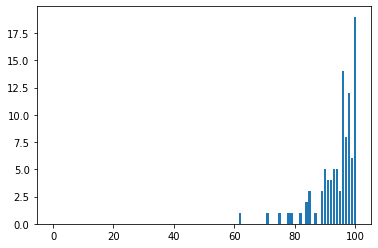

In [17]:
from collections import Counter

bars = Counter(percentils)

X = range(101)
Y = [bars[x] if bars.get(x) is not None else 0 for x in X]

plt.bar(X, Y)

### Conclusions

First of all, original implementation was quite good in terms of code design. Following it step by step it was easy to reimplement it using `qiskit` and make it handle weighted graphs.

The following experiment unveiled the approximate nature of the algorithm - not all found solutions were optimal, however the great majority was impressively good. Almost all results were above 80%, while 100% is the highest bar.